# Exploring the process of iterated learning

### Todo

Need to think hard about the different kinds of scoring:

E.g. Right now we say

$$p(h|D) \propto p(D|h)p(h)$$

where

$$p(D|h) = p(h)\prod_{u_i}^{|D|}\sum_{m'} S(u_i|m', h)p(m')$$

Clearly this is speaker-centric and results in speaker-optimal 'ba' languages (assuming everything in implemented correctly...

What about something that doesn't marginalize out meanings?

$$score(D|h) = \prod_{u_i}^{|D|} KL( L(m|u_i, h) || p(m) )$$

What about **using the cross entropy objective???**


Thinking about 
* https://cocosci.berkeley.edu/tom/papers/IteratedLearningEvolutionLanguage.pdf
* https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=918430

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import tqdm
sys.path.append("/Users/benpeloquin/Desktop/Projects/")
from zipf_principles.ambiguity.matrix import *
from zipf_principles.ambiguity.objectives import *
from zipf_principles.ambiguity.utils import *

### Helpers

A dataset consists of $k$ integer indices representing <u, m> pairs. So if we have a 3 X 3 matrix then the index 0
corresponds to <u_0, m_0>. The 5 index corresponds to <u_1, m_2>

In [2]:
def calc_prob_lang_given_data(model, data):
    scores = []
    for idx in data:
        pr = get_prob(idx, model)
        scores.append(pr)
    return np.prod(scores)

In [3]:
def smooth_matrix_with_epsion(m, eps=1e-08):
    n_rows, n_cols = m.shape
    m_ = np.repeat(eps, n_rows*n_cols).reshape((n_rows, n_cols))
    for i in range(n_rows):
        for j in range(n_cols):
            m_[i][j] += m[i][j]
    return col_normalize(m_)  

In [4]:
def get_prob(idx, m):
    nrow, ncol = m.shape
    if nrow > ncol:
        nrow = nrow - 1
    row = int(np.floor(idx / nrow))
    col = int(idx % ncol)
    return m[row, col]

def row_col_to_idxs(row_num, col_num, nrow=3, ncol=3):
    # Tall matrices
    if nrow > ncol:
        nrow = nrow-1 
    return row_num * nrow + col_num

def generate_utterances_dataset(m_speaker, p_meanings, k=30):
    new_data = []
    for i in range(k):
        m = np.random.choice(range(m_speaker.shape[1]), p=p_meanings)
        u = np.random.choice(range(m_speaker.shape[0]), p=normalize_m(m_speaker[:, m]))
        idx = row_col_to_idxs(u, m, m_speaker.shape[0], m_speaker.shape[1])
        new_data.append(idx)
    return new_data


def get_speaker_given_data(data):
    s1_prob = calc_prob_lang_given_data(s_l1, data)
    s2_prob = calc_prob_lang_given_data(s_l2, data)
    s3_prob = calc_prob_lang_given_data(s_l3, data)
#     s4_prob = calc_prob_lang_given_data(s_l4, data)
    prs = normalize_m(np.array([s1_prob, s2_prob, s3_prob]))
    if np.sum([s1_prob, s2_prob, s3_prob]) == 0:
        raise Exception("bad probs")
    h = np.random.choice(['s1', 's2', 's3'], p=prs)
    return h

# Step-by-step Kanwal

Data is incompatible with lang1, more compatible with lang2 and less compatible with lang3

In [5]:
print("priors")
p_meanings = np.array([0.25, 0.75])
p_utterances = np.array([0.2, 0.2, 0.6])
print(p_utterances)
print(p_meanings)
print("langs")
# lang1 = idxs2matrix([0, 4, 8], 3, 3); print(lang1)
# lang2 = idxs2matrix([0, 4, 5, 8], 3, 3); print(lang2)
# lang3 = idxs2matrix(range(9), 3, 3); print(lang3)
lang1 = idxs2matrix([0, 3, 4, 5], 3, 2); print(lang1)
lang2 = idxs2matrix([0, 5], 3, 2); print(lang2)
lang3 = idxs2matrix([4, 5], 3, 2); print(lang3)
print("speakers")
eps = 0
# s_l1 = speaker(smooth_matrix_with_epsion(lang1, eps), p_utterances, p_meanings, 2, 2); print(s_l1)
# s_l2 = speaker(smooth_matrix_with_epsion(lang2, eps), p_utterances, p_meanings, 2, 2); print(s_l2)
# s_l3 = speaker(smooth_matrix_with_epsion(lang3, eps), p_utterances, p_meanings, 2, 2); print(s_l3)
s_l1 = speaker(lang1, p_utterances, p_meanings, 2, 2); print(s_l1)
s_l2 = speaker(lang2, p_utterances, p_meanings, 2, 2); print(s_l2)
s_l3 = speaker(lang3, p_utterances, p_meanings, 2, 2); print(s_l3)

priors
[0.2 0.2 0.6]
[0.25 0.75]
langs
[[1. 0.]
 [0. 1.]
 [1. 1.]]
[[1. 0.]
 [0. 0.]
 [0. 1.]]
[[0. 0.]
 [0. 0.]
 [1. 1.]]
speakers
[[0.98237274 0.        ]
 [0.         0.28137985]
 [0.01762726 0.71862015]]
[[1. 0.]
 [0. 0.]
 [0. 1.]]
[[0. 0.]
 [0. 0.]
 [1. 1.]]


/Users/benpeloquin/Desktop/Projects/zipf_principles/ambiguity/matrix.py:38: RuntimeWarning: divide by zero encountered in log
  return row_normalize(col_multiply(np.exp(np.log(M)), p_meanings))
/Users/benpeloquin/Desktop/Projects/zipf_principles/ambiguity/matrix.py:42: RuntimeWarning: divide by zero encountered in log
  return col_normalize(row_multiply(np.exp(alpha * np.log(M)), p_utterances))
/Users/benpeloquin/Desktop/Projects/zipf_principles/ambiguity/matrix.py:17: RuntimeWarning: invalid value encountered in divide
  M = np.nan_to_num((m.transpose() / totals).transpose())


In [6]:
data = [0, 3, 5]

In [8]:
nrow, ncol = s_l1.shape
s1_prob = calc_prob_lang_given_data(s_l1, data)
s2_prob = calc_prob_lang_given_data(s_l2, data)
s3_prob = calc_prob_lang_given_data(s_l3, data)
probs = normalize_m(np.array([s1_prob, s2_prob, s3_prob])); print(probs)

[1. 0. 0.]


We select a new language (probability match or MAP) with probability matching.

$$p(h|d)$$

In [10]:
speaker_models = {
    's1': s_l1,
    's2': s_l2,
    's3': s_l3
}
probs = normalize_m(np.array([s1_prob, s2_prob, s3_prob])); print(probs)
s_generator_name = np.random.choice(['s1', 's2', 's3'], p=probs); print(s_generator_name)
s_generator = speaker_models[s_generator_name]

[1. 0. 0.]
s1


We generate a new dataset
$$p(d|h)$$

In [11]:
# generate_utterances_dataset(m_speaker, p_meanings, k=30)
new_d = generate_utterances_dataset(s_generator, p_meanings, k=10); new_d

[5, 5, 5, 5, 5, 3, 0, 5, 3, 5]

Now we re-calcualte p(h|d)

In [13]:
s1_prob = calc_prob_lang_given_data(s_l1, new_d)
s2_prob = calc_prob_lang_given_data(s_l2, new_d)
s3_prob = calc_prob_lang_given_data(s_l3, new_d)
probs = normalize_m(np.array([s1_prob, s2_prob, s3_prob])); print(probs)
s_generator_name = np.random.choice(['s1', 's2', 's3'], p=probs); print(s_generator_name)
s_generator = speaker_models[s_generator_name]

[1. 0. 0.]
s1


In [ ]:
speaker_models = {
    's1': s_l1,
    's2': s_l2,
    's3': s_l3
}
probs = normalize_m(np.array([s1_prob, s2_prob, s3_prob])); print(probs)
s_generator_name = np.random.choice(['s1', 's2', 's3'], p=probs); print(s_generator_name)
s_generator = speaker_models[s_generator_name]

### Multiple kanwal simulations

setup

In [416]:
def get_speaker_given_data(s1_m, s2_m, s3_m, s4_m, data):
    s1_prob = calc_prob_lang_given_data(s1_m, data)
    s2_prob = calc_prob_lang_given_data(s2_m, data)
    s3_prob = calc_prob_lang_given_data(s3_m, data)
#     s4_prob = calc_prob_lang_given_data(s4_m, data)
    prs = normalize_m(np.array([s1_prob, s2_prob, s3_prob, s4_prob]))
    if np.sum([s1_prob, s2_prob, s3_prob, s4_prob]) == 0:
        raise Exception("bad probs")
    h = np.random.choice(['s1', 's2', 's3', 's4'], p=prs)
    return h, prs

In [417]:
print("priors")
p_meanings = np.array([0.25, 0.75])
p_utterances = np.array([0.25, 0.25, 0.5])
print(p_utterances)
print(p_meanings)
print("langs")
# lang1 = idxs2matrix([0, 4, 8], 3, 3); print(lang1)
# lang2 = idxs2matrix([0, 4, 5, 8], 3, 3); print(lang2)
# lang3 = idxs2matrix(range(9), 3, 3); print(lang3)
lang1 = idxs2matrix([0, 3, 4, 5], 3, 2)
lang2 = idxs2matrix([0, 5], 3, 2)
lang3 = idxs2matrix([0, 3], 3, 2)
lang4 = idxs2matrix([4, 5], 3, 2)
print("speakers")
# eps = 0.00001
# s_l1 = speaker(smooth_matrix_with_epsion(lang1, eps), p_utterances, p_meanings, 2, 2); print(np.round(s_l1, 8))
# s_l2 = speaker(smooth_matrix_with_epsion(lang2, eps), p_utterances, p_meanings, 2, 2); print(np.round(s_l2, 8))
# s_l3 = speaker(smooth_matrix_with_epsion(lang3, eps), p_utterances, p_meanings, 2, 2); print(np.round(s_l3, 8))
# s_l4 = speaker(smooth_matrix_with_epsion(lang4, eps), p_utterances, p_meanings, 2, 2); print(np.round(s_l4, 8))
s_l1 = speaker(lang1, p_utterances, p_meanings, 2, 2); print(s_l1)
s_l2 = speaker(lang2, p_utterances, p_meanings, 2, 2); print(s_l2)
s_l3 = speaker(lang3, p_utterances, p_meanings, 2, 2); print(s_l3)
# s_l4 = speaker(lang4, p_utterances, p_meanings, 2, 2); print(s_l4)
speaker_models = {
    's1': s_l1,
    's2': s_l2,
    's3': s_l3,
#     's4': s_l4
}

priors
[0.25 0.25 0.5 ]
[0.25 0.75]
langs
speakers
[[0.99152219 0.        ]
 [0.         0.36403192]
 [0.00847781 0.63596808]]
[[1. 0.]
 [0. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]
 [0. 0.]]


In [419]:
data = [0, 3, 5]
for i in range(100):
    s_name, prs = get_speaker_given_data(s_l1, s_l2, s_l3, data)
    print(s_name, prs)
    data = generate_utterances_dataset(speaker_types[s_name], p_meanings, k=i)

TypeError: get_speaker_given_data() takes exactly 5 arguments (4 given)

In [420]:
init_data = []
N_sims = 10
data = [0, 3, 5]
results = []
for sim in range(N_sims):
    sim_num = 0
    while (h != 's2' or sim_num < 10):
        h, prs = get_speaker_given_data(s_l1, s_l2, s_l3, s_l4, data)
        m_speaker = speaker_types[h]
        results.append({
            'generation': sim_num,
            'sim_id': sim,
            "speaker": h,
            "s1_pr": prs[0],
            "s2_pr": prs[1],
            "s3_pr": prs[2],
            "s4_pr": prs[3],
        })
        sim_num += 1
        data = generate_utterances_dataset(m_speaker, p_meanings, k=10)
        
        

In [421]:
df_results = pd.DataFrame(results)

(0, 1)

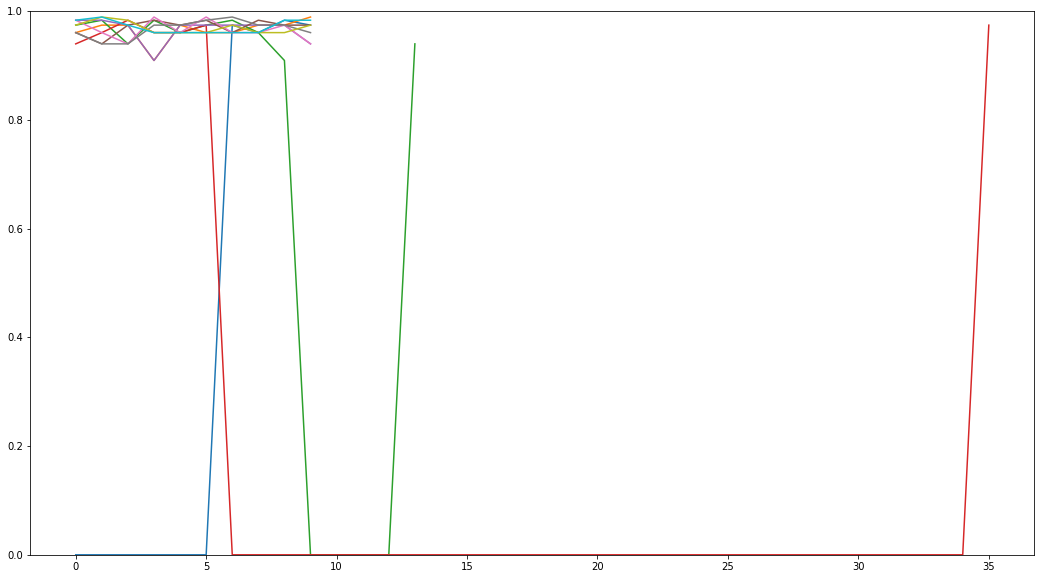

In [422]:
plt.figure(figsize=(18, 10))
for sim_id in set(df_results['sim_id']):
    curr_df = df_results[df_results['sim_id']==sim_id]
    plt.plot(curr_df['generation'], curr_df['s2_pr'])
plt.ylim(0, 1)

# Population dynamics simulation

In [368]:
print("priors")
p_meanings = np.array([0.25, 0.75])
p_utterances = np.array([0.2, 0.2, 0.6])
print(p_utterances)
print(p_meanings)
print("langs")
lang1 = idxs2matrix([0, 3, 4, 5], 3, 2); print(lang1)
lang2 = idxs2matrix([0, 5], 3, 2); print(lang2)
lang3 = idxs2matrix([0, 3], 3, 2); print(lang3)
lang4 = idxs2matrix([4, 5], 3, 2); print(lang4)
print("speakers")
eps = 0
# s_l1 = speaker(smooth_matrix_with_epsion(lang1, eps), p_utterances, p_meanings, 2, 2); print(s_l1)
# s_l2 = speaker(smooth_matrix_with_epsion(lang2, eps), p_utterances, p_meanings, 2, 2); print(s_l2)
# s_l3 = speaker(smooth_matrix_with_epsion(lang3, eps), p_utterances, p_meanings, 2, 2); print(s_l3)
s_l1 = speaker(lang1, p_utterances, p_meanings, 10, 2); print(s_l1)
s_l2 = speaker(lang2, p_utterances, p_meanings, 10, 2); print(s_l2)
s_l3 = speaker(lang3, p_utterances, p_meanings, 10, 2); print(s_l3)
s_l4 = speaker(lang4, p_utterances, p_meanings, 10, 2); print(s_l4)

priors
[0.2 0.2 0.6]
[0.25 0.75]
langs
[[1. 0.]
 [0. 1.]
 [1. 1.]]
[[1. 0.]
 [0. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]
 [1. 1.]]
speakers
[[1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.50012373e-01]
 [4.69533274e-52 7.49987627e-01]]
[[1. 0.]
 [0. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]
 [1. 1.]]


In [393]:
speaker_population = []
K_generations = 10
N_sims = 100
init_data = [0]
speaker_types = {
    's1': s_l1,
    's2': s_l2,
    's3': s_l3,
    's4': s_l4,
}



speaker_population = ['s1']
res = []
generation_tracker = []
num_teachers = 1
for generation in range(K_generations):
    current_generation = []
    new_speaker_num = 2 * len(speaker_population)
    for num_new_speakers in range(new_speaker_num):
        # New data is a sample from num_teachers of the previous speaker pop
        new_data = []
        num_teachers = len(speaker_population) /2
        for teacher_num in range(num_teachers):
            teacher = np.random.choice(speaker_population)
            teacher_m = speaker_types[teacher]
            new_data.extend(generate_utterances_dataset(teacher_m, p_meanings, k=np.random.choice(range(3, 6))))
        learner = get_speaker_given_data(new_data)
        current_generation.append(learner)
    speaker_population = current_generation
    current_generation_counts = Counter(current_generation)
    current_generation_counts['generation'] = generation
    generation_tracker.append(current_generation_counts)

generation_probs_tracker = []
for generation in generation_tracker:
    total = np.sum([generation[typ] for typ in speaker_types.keys()])
    for typ in speaker_types.keys():
        generation['{}_prob'.format(typ)] = generation[typ] / float(total)
    
    

KeyboardInterrupt: 

In [ ]:
generation_tracker

### Few steps of kanwal et al. example.

In [79]:
print("priors")
p_meanings = np.array([0.25, 0.75])
p_utterances = np.array([0.2, 0.2, 0.6])
print(p_utterances)
print(p_meanings)
print("langs")
# lang1 = idxs2matrix([0, 4, 8], 3, 3); print(lang1)
# lang2 = idxs2matrix([0, 4, 5, 8], 3, 3); print(lang2)
# lang3 = idxs2matrix(range(9), 3, 3); print(lang3)
lang1 = idxs2matrix([0, 3, 4, 5], 3, 2); print(lang1)
lang2 = idxs2matrix([0, 5], 3, 2); print(lang2)
lang3 = idxs2matrix([4, 5], 3, 2); print(lang3)
print("speakers")
eps = 0
# s_l1 = speaker(smooth_matrix_with_epsion(lang1, eps), p_utterances, p_meanings, 2, 2); print(s_l1)
# s_l2 = speaker(smooth_matrix_with_epsion(lang2, eps), p_utterances, p_meanings, 2, 2); print(s_l2)
# s_l3 = speaker(smooth_matrix_with_epsion(lang3, eps), p_utterances, p_meanings, 2, 2); print(s_l3)
s_l1 = speaker(lang1, p_utterances, p_meanings, 2, 2); print(s_l1)
s_l2 = speaker(lang2, p_utterances, p_meanings, 2, 2); print(s_l2)
s_l3 = speaker(lang3, p_utterances, p_meanings, 2, 2); print(s_l3)

priors
[0.2 0.2 0.6]
[0.25 0.75]
langs
[[1. 0.]
 [0. 1.]
 [1. 1.]]
[[1. 0.]
 [0. 0.]
 [0. 1.]]
[[0. 0.]
 [0. 0.]
 [1. 1.]]
speakers
[[0.98237274 0.        ]
 [0.         0.28137985]
 [0.01762726 0.71862015]]
[[1. 0.]
 [0. 0.]
 [0. 1.]]
[[0. 0.]
 [0. 0.]
 [1. 1.]]


Vary:

* init data (np.random.choice())
* halt iteration if k steps are conventionalization has occured

In [86]:
def is_conventional(l):
    return l == 's1'

K_generations = 100
N_sims = 100
init_data = np.random.choice(range(len(p_meanings)*len(p_utterances)), size=10).tolist()

hyp2m = {
    's1': s_l1,
    's2': s_l2,
    's3': s_l3,
}

results = []
for sim_id in tqdm.tqdm(range(N_sims)):
    for k in range(K_generations):
        s1_prob = calc_prob_lang_given_data(s_l1, data)
        s2_prob = calc_prob_lang_given_data(s_l2, data)
        s3_prob = calc_prob_lang_given_data(s_l3, data)
        prs = normalize_m(np.array([s1_prob, s2_prob, s3_prob]))
        h = np.random.choice(['s1', 's2', 's3'], p=prs)
        m = hyp2m[h]
    #     history = np.random.choice(data, size=20).tolist()
    #     history = data
    #     history = []
        data = generate_utterances_dataset(m, p_meanings, k=4)
        results.append({
            'generation': k,
            'h1_pr': prs[0],
            'h2_pr': prs[1],
            'h3_pr': prs[2],
            'current': h,
            'sim_id': sim_id
        }) 
#         if is_conventional(h):
#             break
df_results = pd.DataFrame(results)

100%|██████████| 100/100 [00:03<00:00, 28.02it/s]


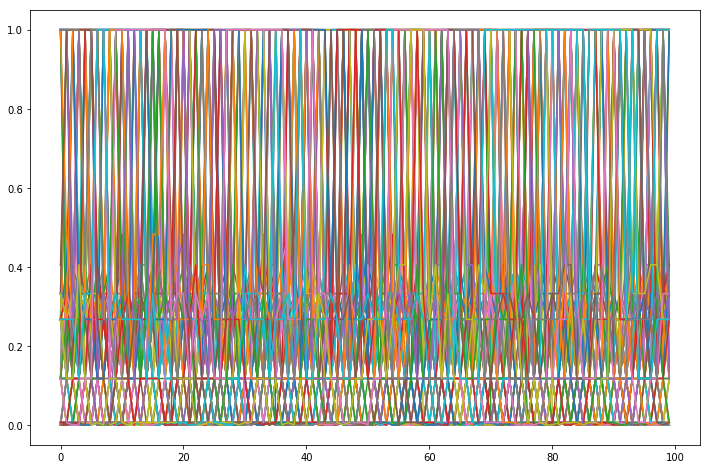

In [87]:
plt.figure(figsize=(12, 8))

for sim_id in set(df_results['sim_id']):
    curr_df = df_results[df_results['sim_id']==sim_id]
    plt.plot(curr_df['generation'], curr_df['h1_pr'])

In [262]:
new_d = generate_utterances_dataset(s_generator, p_meanings, k=10); new_d

[5, 5, 0, 5, 5, 5, 5, 5, 5, 0]

In [265]:
s1_prob = calc_prob_lang_given_data(s_l1, new_d)
s2_prob = calc_prob_lang_given_data(s_l2, new_d)
s3_prob = calc_prob_lang_given_data(s_l3, new_d)
probs = normalize_m(np.array([s1_prob, s2_prob, s3_prob])); print(probs)
s_generator_name = np.random.choice(['s1', 's2', 's3'], p=probs); print(s_generator_name)
s_generator = speaker_models[s_generator_name]

[0.06422708 0.93577292 0.        ]
s2


In [242]:
new_d = generate_utterances_dataset(s_generator, p_meanings, k=10); new_d

[5, 3, 3, 5, 5, 3, 0, 5, 5, 5]

In [244]:
s1_prob = calc_prob_lang_given_data(s_l1, new_d)
s2_prob = calc_prob_lang_given_data(s_l2, new_d)
s3_prob = calc_prob_lang_given_data(s_l3, new_d)
s4_prob = calc_prob_lang_given_data(s_l4, new_d)
probs = normalize_m(np.array([s1_prob, s2_prob, s3_prob, s4_prob])); print(probs)
s_generator_name = np.random.choice(['s1', 's2', 's3', 's4'], p=probs); print(s_generator_name)
s_generator = speaker_models[s_generator_name]

[1. 0. 0. 0.]
s1


In [26]:
K_generations = 10
init_data = np.random.choice(range(6), size=30).tolist()

hyp2m = {
    's1': s_l1,
    's2': s_l2,
    's3': s_l3,
}

results = []
for k in range(K_generations):
    s1_prob = calc_prob_lang_given_data(s_l1, data)
    s2_prob = calc_prob_lang_given_data(s_l2, data)
    s3_prob = calc_prob_lang_given_data(s_l3, data)
    prs = normalize_m(np.array([s1_prob, s2_prob, s3_prob]))
    if k % 10 == 0:
        print(prs)
    h = np.random.choice(['s1', 's2', 's3'], p=prs)
    m = hyp2m[h]
#     history = np.random.choice(data, size=20).tolist()
    history = data
#     history = []
    data = history + generate_utterances_dataset(m, p_meanings, k=4)
    results.append({
        'generation': k,
        'h1_pr': prs[0],
        'h2_pr': prs[1],
        'h3_pr': prs[2],
        'current': h
    }) 
df_results = pd.DataFrame(results)

[1.00000000e+00 3.39411214e-48 3.21396600e-21]


In [27]:
df_results

,current,generation,h1_pr,h2_pr,h3_pr
0,s1,0,1.0,3.394112e-48,3.213966e-21
1,s1,1,1.0,1.525125e-48,9.636150e-22
2,s1,2,1.0,2.242093e-48,4.682862e-22
3,s1,3,1.0,3.010379e-48,5.549080e-23
4,s1,4,1.0,3.691543e-48,1.603365e-24
5,s1,5,1.0,4.526836e-48,4.632803e-26
6,s1,6,1.0,3.739313e-48,1.139567e-27
7,s1,7,1.0,5.020642e-48,1.350360e-28
8,s1,8,1.0,4.147213e-48,3.321589e-30
9,s1,9,1.0,2.766466e-48,1.169832e-30


# Generalized simulations

In [28]:
p_utterances = np.array([0.1, 0.2, 0.7])
p_meanings = np.array([0.1, 0.2, 0.7])
lang1 = idxs2matrix([0, 4, 8], 3, 3); print(lang1)
lang2 = idxs2matrix([0, 4, 5, 8], 3, 3); print(lang2)
lang3 = idxs2matrix([0, 4, 5, 7, 8], 3, 3); print(lang3)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 1.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 1.]
 [0. 1. 1.]]


In [47]:
# Lang / speakers
eps = 0.001
s_l1 = speaker(lang1, p_utterances, p_meanings, 1, 2)
s_l2 = speaker(lang2, p_utterances, p_meanings, 1, 2)
s_l3 = speaker(lang3, p_utterances, p_meanings, 1, 2)
m_s1 = smooth_matrix_with_epsion(s_l1, eps); print(np.round(m_s1, 3)); print()
m_s2 = smooth_matrix_with_epsion(s_l2, eps); print(np.round(m_s2, 3)); print()
m_s3 = smooth_matrix_with_epsion(s_l3, eps); print(np.round(m_s3, 3)); print()

[[0.998 0.001 0.001]
 [0.001 0.998 0.001]
 [0.001 0.001 0.998]]
()
[[0.998 0.001 0.001]
 [0.001 0.998 0.101]
 [0.001 0.001 0.898]]
()
[[0.998 0.001 0.001]
 [0.001 0.223 0.223]
 [0.001 0.776 0.776]]
()


In [40]:
# m_s1 = smooth_matrix_with_epsion(s_l1, 0.01); print(m_s1)
# m_s2 = smooth_matrix_with_epsion(s_l2, 0.01); print(m_s2)
# m_s3 = smooth_matrix_with_epsion(s_l3, 0.01); print(m_s3)
# init_data = [8, 8, 4, 8, 0, 0, 1, 2, 2]
# prs = [calc_prob_lang_given_data(m_s1, data), 
#        calc_prob_lang_given_data(m_s2, data), 
#        calc_prob_lang_given_data(m_s3, data)]
# print(normalize_m(prs))

In [41]:
K_generations = 100
init_data = np.random.choice(range(9), size=30).tolist()

hyp2m = {
    's1': m_s1,
    's2': m_s2,
    's3': m_s3,
}

results = []
for k in range(K_generations):
    s1_prob = calc_prob_lang_given_data(m_s1, data)
    s2_prob = calc_prob_lang_given_data(m_s2, data)
    s3_prob = calc_prob_lang_given_data(m_s3, data)
    prs = normalize_m(np.array([s1_prob, s2_prob, s3_prob]))
    if k % 10 == 0:
        print(prs)
    h = np.random.choice(['s1', 's2', 's3'], p=prs)
    m = hyp2m[h]
#     history = np.random.choice(data, size=20).tolist()
    history = data
#     history = []
    data = history + generate_utterances_dataset(m, p_meanings, k=4)
    results.append({
        'generation': k,
        'h1_pr': prs[0],
        'h2_pr': prs[1],
        'h3_pr': prs[2],
        'current': h
    }) 
df_results = pd.DataFrame(results)

[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]


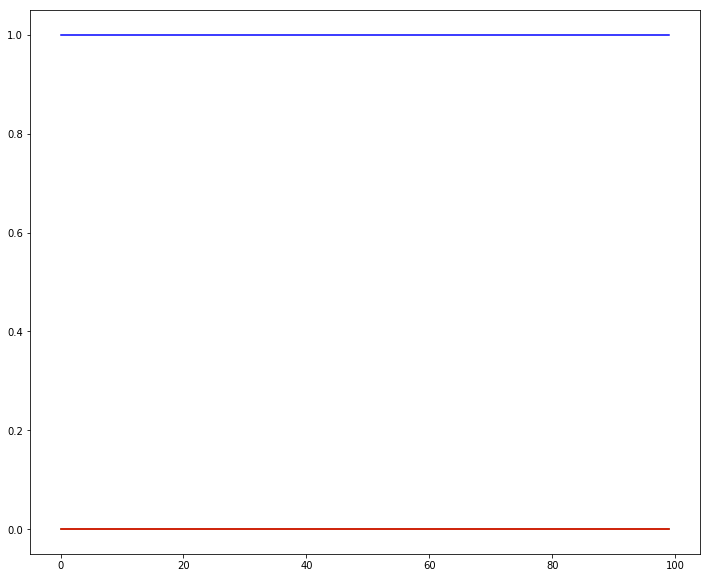

In [42]:
plt.figure(figsize=(12, 10))
plt.plot(df_results['generation'], df_results['h1_pr'], color='green')
plt.plot(df_results['generation'], df_results['h2_pr'], color='red')
plt.plot(df_results['generation'], df_results['h3_pr'], color='blue')

In [520]:
all_langs = []
for n in range(3, 10):
    all_langs.extend(generate_all_boolean_matrices(3, 3, n))
    
valid_langs = []
for idxs, m in all_langs:
    if is_valid_matrix(m, all_meanings_available_filter):
        valid_langs.append((idxs, m))

In [188]:
p_utterances = np.array([0.1, 0.2, 0.7])
p_meanings = np.array([0.1, 0.2, 0.7])

In [189]:
def get_prob(idx, m):
    row = int(np.floor(idx / m.shape[0]))
    col = int(idx % m.shape[1])
    return m[row, col]


(1) 
$$p(D|h) = p(h)\prod_{u_i}^{|D|}\sum_{m'} S(u_i|m', h)p(m')$$

(2) temp 
$$score(D|h) = \frac{1}{|D|}\sum_{u_i}^{|D|}L(m |u, h) \times -log_2(p(m))$$

In [203]:
def calc_dataset_prob(data, m_speaker, m_listener, p_meanings, p_h):
    # Each d is an utterance (row)
    invalid_listener_matrix = False
    all_probs = []
    all_meanings = []
    n_rows, n_cols = m_speaker.shape
    for d in data:
        probs = []
        # Speaker cost
        for idx in range(n_cols):
            pr = get_prob(d*n_rows + idx, m_speaker) * p_meanings[idx]
            probs.append(pr)
        all_probs.append(probs)
        
        # Listener based cost
        p_ms = m_listener[d, : ]
        if np.sum(p_ms) == 0:
            invalid_listener_matrix = True
            continue
        m_prime = np.random.choice(range(len(p_meanings)), p=normalize_m(p_ms))
        all_meanings.append(m_prime)
    meanings_cnt = Counter(all_meanings)
    listener_score = -np.inf
    # If this is a valid matrix then continue with
    # listener score computation
    if not invalid_listener_matrix:
        listener_score = 0
        total = np.sum(meanings_cnt.values()).astype(float)
        for i in range(len(p_meanings)):
            pr = meanings_cnt[i] / total if meanings_cnt[i] != 0 else 1
            listener_score += np.log2(pr)
    
    return p_h*np.prod(np.sum(all_probs, axis=1)), np.exp2(listener_score), all_probs

### Generate a new dataset

```
new_data = []
for i in |D|:
    m = sample(p_meanings)
    u = sample(speaker(m))
    new_data.append(u)
    
```


In [207]:
def score_h_given_d(data, langs, p_utterances, p_meanings, alpha, k):
    """
    p(h|d) = [p(d|h) * p(h)] / p(d)
    
    """
    lang_probs = []
    total = 0.
    total_listener_scores = 0.
    for idxs, lang in langs:
        m_speaker = speaker(lang, p_utterances, p_meanings, alpha=alpha, k=k)
        m_listener = listener(lang, p_utterances, p_meanings, alpha=alpha, k=k)
        pr_lang, listener_score, _ = \
            calc_dataset_prob(data, m_speaker, m_listener, p_meanings, 1./len(valid_langs))
        lang_probs.append((idxs, pr_lang, np.exp2(listener_score)))
        total += pr_lang
        total_listener_scores += listener_score
    lang_probs_normalized = []
    listener_probs_normalized = []
    for idxs, pr_lang, listener_score in lang_probs:
        lang_probs_normalized.append((idxs, pr_lang / total))
        listener_probs_normalized.append((idxs, listener_score / total_listener_scores))
        
    return lang_probs_normalized, listener_probs_normalized


def generate_utterances_dataset(m_speaker, p_meanings, k=30):
    new_data = []
    for i in range(k):
        m = np.random.choice(range(m_speaker.shape[1]), p=p_meanings)
        u = np.random.choice(range(m_speaker.shape[0]), p=m_speaker[:, m])
        new_data.append(u)
    return new_data
# calc_p_h_given_d(new_data, valid_langs, p_utterances, p_meanings, 1., 1)

def sample_h_star(idxs, probs):
    return np.random.choice(idxs, p=probs)

def greedy_h_star(idxs, probs):
    new_h = zip(idxs, probs)
    return max(new_h, key=lambda x: x[1])[0]

def get_idxs_and_probs(H):
    idxs = [idxs for idxs, _ in H]
    probs = [probs for _, probs in H]
    return idxs, probs
    
def lang_to_speaker_matrix(lang, alpha=1, k=1):
    return speaker(lang, p_utterances, p_meanings, alpha, k)

In [208]:
init_data = np.random.choice([0, 1, 2], 30, p=[0.35, 0.35, 0.3])
Counter(init_data)

Counter({0: 13, 1: 4, 2: 13})

In [219]:
N_SIMS = 1
k = 3
alpha = 2
n_rounds = 10
results = []
data = init_data
for sim_id in range(N_SIMS):
    for r in tqdm.tqdm(range(n_rounds)):
        data_counts = Counter(data)
        H_speaker, H_listener = score_h_given_d(data, valid_langs, p_utterances, p_meanings, alpha, k)
        for i, _ in enumerate(H_speaker):
            idxs = H_speaker[i][0]
            pr = H_speaker[i][1]
            listener_pr = H_listener[i][1]
            results.append({
                'sim_id': sim_id,
                'round': r,
                'idxs': idxs,
                'p_h_d': pr,
                'listener_score': listener_pr,
                '0': data_counts[0],
                '1': data_counts[1],
                '2': data_counts[2]
            })
        idxs, probs = get_idxs_and_probs(H_listener) 
        new_idxs = greedy_h_star(idxs, probs)
        new_lang = idxs2matrix(new_idxs, 3, 3)
        m_speaker = lang_to_speaker_matrix(new_lang, alpha, k)
        data = generate_utterances_dataset(m_speaker, p_meanings, 30)













  0%|          | 0/10 [00:00<?, ?it/s]











 10%|█         | 1/10 [00:00<00:06,  1.47it/s]











 20%|██        | 2/10 [00:01<00:05,  1.44it/s]











 30%|███       | 3/10 [00:02<00:04,  1.43it/s]











 40%|████      | 4/10 [00:02<00:04,  1.42it/s]











 50%|█████     | 5/10 [00:03<00:03,  1.40it/s]











 60%|██████    | 6/10 [00:04<00:02,  1.38it/s]











 70%|███████   | 7/10 [00:05<00:02,  1.37it/s]











 80%|████████  | 8/10 [00:06<00:01,  1.33it/s]











 90%|█████████ | 9/10 [00:06<00:00,  1.30it/s]











100%|██████████| 10/10 [00:07<00:00,  1.30it/s]













In [215]:
df = pd.DataFrame(results)
df.tail()

,0,1,2,idxs,listener_score,p_h_d,round,sim_id
3425,3,5,22,"(0, 1, 2, 4, 5, 6, 7, 8)",0.216661,0.008738,9,0
3426,3,5,22,"(0, 1, 3, 4, 5, 6, 7, 8)",0.216828,0.008700,9,0
3427,3,5,22,"(0, 2, 3, 4, 5, 6, 7, 8)",0.217296,0.008731,9,0
3428,3,5,22,"(1, 2, 3, 4, 5, 6, 7, 8)",0.216973,0.008731,9,0
3429,3,5,22,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",0.217196,0.008731,9,0


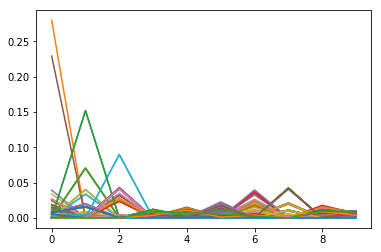

In [220]:
for idx in set(df['idxs']):
    curr_d = df[df["idxs"]==idx]
    plt.plot(curr_d["round"], curr_d["p_h_d"])

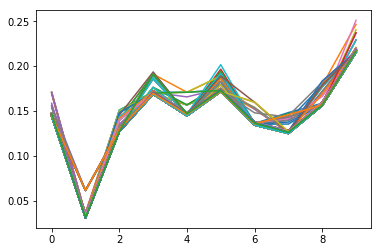

In [221]:
for idx in set(df['idxs']):
    curr_d = df[df["idxs"]==idx]
    plt.plot(curr_d["round"], curr_d["listener_score"])

<BarContainer object of 10 artists>

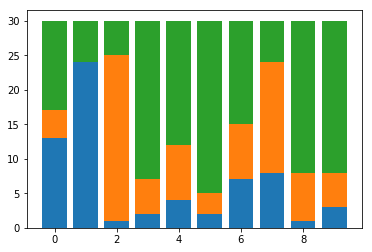

In [222]:
df_counts = df[['0', '1', '2', 'round']] \
    .drop_duplicates()
plt.bar(df_counts['round'], df_counts['0'])
plt.bar(df_counts['round'], df_counts['1'], bottom=df_counts['0'])
plt.bar(df_counts['round'], df_counts['2'], bottom=df_counts['1']+df_counts['0'])

In [226]:
df[df["round"] == 9] \
    .sort_values(by=['listener_score'], ascending=False) \
    .head()

,0,1,2,idxs,listener_score,p_h_d,round,sim_id
3404,3,5,22,"(0, 1, 4, 5, 6, 7, 8)",0.251034,8.668875e-03,9,0
3285,3,5,22,"(2, 3, 4, 5, 7)",0.246437,2.145505e-11,9,0
3306,3,5,22,"(0, 1, 2, 3, 4, 8)",0.240438,4.956642e-03,9,0
3142,3,5,22,"(0, 4, 5, 6)",0.236945,4.264827e-22,9,0
3162,3,5,22,"(1, 3, 5, 7)",0.236945,7.941247e-15,9,0
